In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math


EJERCICIO 1: CORRELACION

Funciones utilizadas


In [2]:
def convertir_a_gris_float(ruta):
    """
    Lee imagen en escala de grises y la devuelve como float32.
    """
    img = cv2.imread(ruta, cv2.IMREAD_GRAYSCALE)
    #Validacion de apertura del archivo
    if img is not None:
        raise FileNotFoundError(ruta)
    return img.astype(np.float32)

def asegurar_filas_pares(img):
    """
    Para formar pares verticales (2x1) necesito cantidad par de filas.
    Si es impar, descarto la última.
    """
    return img if (img.shape[0] % 2 == 0) else img[:-1, :]

def imagen_a_pares(img):
    """
    Agrupa en pares los pixeles verticales contiguos.
    """
    img = asegurar_filas_pares(img)
    # traspongo y achato toda la matriz en un vector
    v = img.T.ravel()         
    # devuelve un vector con todos los pixeles pares
    X1 = v[0::2]           
    # devuelve un vector con todos los pixeles impares  
    X2 = v[1::2]                  
    # Apila en forma de stack vertical los pares (X1,X2) y forma una "matriz" de (N,2)
    return np.vstack([X1, X2]).T 

def graficar_imagen_y_dispersion(img, X, titulo):
    """
    Muestra imagen y scatter (X1 vs X2). 
    """
    fig, ejes = plt.subplots(1, 2, figsize=(10, 4))
    ejes[0].imshow(img, cmap="gray")
    ejes[0].set_title("Imagen"); ejes[0].axis("off")
    ejes[1].scatter(X[:,0], X[:,1], s=1, alpha=0.5)
    ejes[1].set_xlabel("X1 - Pixel Superior")
    ejes[1].set_ylabel("X2 - Pixel Inferior")
    ejes[1].set_title(titulo)
    ejes[1].set_aspect('equal', adjustable='box')
    plt.tight_layout(); plt.show()

def correlacion_pearson(X):
    """p = corr(X1, X2)."""
    return float(np.corrcoef(X[:,0], X[:,1])[0,1])

def descorrelacion_pca(X):
    """
    Aplica PCA en 2D a la matriz de pares, retorna (Y) que es la matriz descorrelacionada, 
    un vector 2x1 con la media de cada columna, (P) la matriz de autovectores y (autoval) 
    los dos autovalores asociados.
    """
    # Calculo la media de cada columna de valores, devuelve matrix de 1x2
    media = X.mean(axis=0, keepdims=True)    
    # Resto la media correspondiente de cada columna a los pares de valores, devuelve matrix de Nx2
    Xc = X - media
    # El metodo shape devuelve el numero de filas 
    N = X.shape[0]
    # Calculo matriz de convarianza muestral, devuelve una matrix de 2x2
    C = (Xc.T @ Xc) / (N - 1)   
    # np.linalg.eight aprovecha que la matriz de covarianza es simetrica y calcula los autovalores y autovectores             
    autoval, autovec = np.linalg.eigh(C)  
    # Ordena los indices de los autovalores de mayor a menor
    idx = np.argsort(autoval)[::-1] 
    # Reordena los autovalores de mayor a menor (python acepta la lista de indices para ordenar, está OP)     
    autoval = autoval[idx]
    # Ordena los auto vectores acorde a los autovalores, devuelve matrix 2x2
    P = autovec[:, idx]   
    # Proyecta los datos en los ejes principales, aplica PCA basicamente. Devuelve matriz Nx2                   
    Y = Xc @ P                               
    return Y, media.ravel(), P, autoval



In [4]:
# Imagen 1
img1 = convertir_a_gris_float("./img_01.jpg")
X1 = imagen_a_pares(img1)
rho1 = correlacion_pearson(X1)
graficar_imagen_y_dispersion(img1, X1, titulo=f"DISPERSION (X1,X2), ρ={rho1:.4f}")

# Imagen 2
img2 = convertir_a_gris_float("./img_02.jpg")
X2 = imagen_a_pares(img2)
rho2 = correlacion_pearson(X2)
graficar_imagen_y_dispersion(img2, X2, titulo=f"DISPERSION (X1,X2), ρ={rho2:.4f}")




FileNotFoundError: ./img_01.jpg

Conclusion Ejercicio 1a)

El gráfico de dispersión muestra la relación entre el valor de un píxel y el valor del píxel de abajo en la imagen. Cada punto representa un par (píxel superior, píxel inferior). Si los puntos se agrupan cerca de la diagonal, significa que los valores de píxeles vecinos son similares y hay alta correlación.

Ejercicio 1b)

Estimar el coeficiente de correlacion de cada vector. ¿Que diferencias observa para ambas
imagenes? ¿Cual de ellas podrıa comprimir la informacion con una mayor calidad?


In [66]:
print(f"Correlación Imagen 1: p={rho1:.4f}")
print(f"Correlación Imagen 2: p={rho2:.4f}")

Correlación Imagen 1: p=0.9792
Correlación Imagen 2: p=0.1452


La correlación de Pearson mide cuán relacionados están los valores de los píxeles vecinos. Un valor cercano a 1 indica que los píxeles tienden a tener valores similares (alta correlación). Un valor cercano a 0 indica que no hay relación.

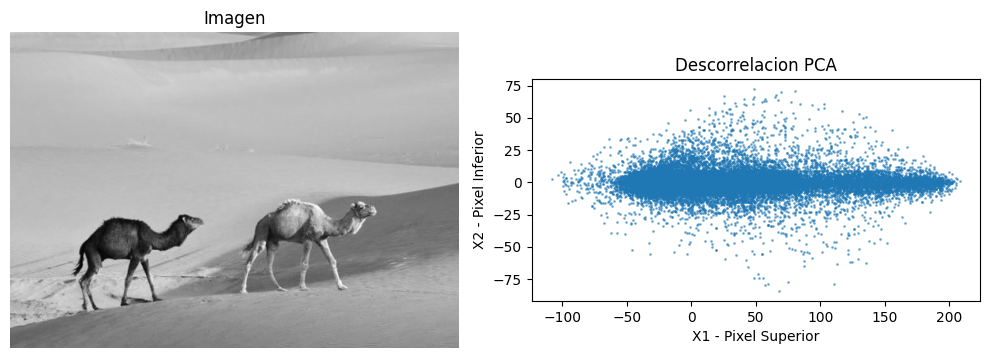

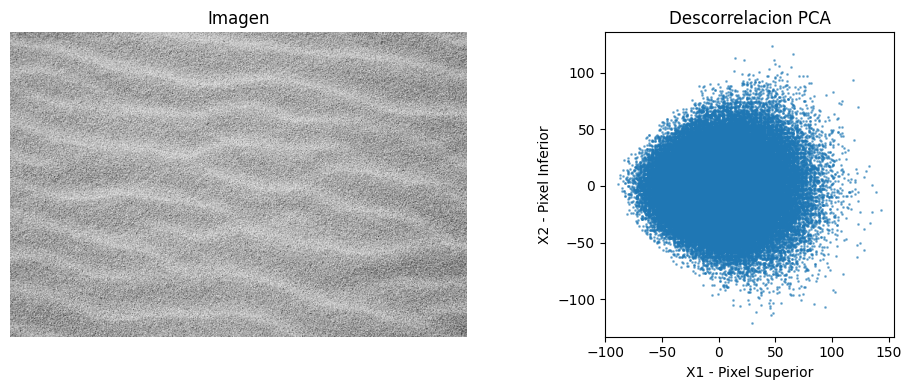

In [67]:
Y1, media1, P1, autoval1 = descorrelacion_pca(X1)
Y2, media2, P2, autoval2 = descorrelacion_pca(X2)

graficar_imagen_y_dispersion(img1, Y1, titulo=f"Descorrelacion PCA")
graficar_imagen_y_dispersion(img2, Y2, titulo=f"Descorrelacion PCA")


EJERCICIO 2


In [68]:
def imagen_a_bloques(imagen, alto_bloque: int = 8, ancho_bloque: int = 8) -> np.ndarray:
    """
    Divide una imagen en escala de grises en bloques aplanados.
    Devuelve una matriz X de tamaño (n_bloques, alto_bloque*ancho_bloque).
    """
    alto, ancho = imagen.shape
    # Calculamos los cortes de la imagen para tener una imagen con medidas multiplos de 8 en nuestro caso
    alto_corte = alto - (alto % alto_bloque)
    ancho_corte = ancho - (ancho % ancho_bloque)
    bloques = []
    # Recorrer la imagen en pasos de 8 píxeles
    for i in range(0, alto_corte, alto_bloque):
        for j in range(0, ancho_corte, ancho_bloque):
            # Selecciona un bloque de la imagen (en nuestro caso se usa 8x8)
            bloque = imagen[i:i+alto_bloque, j:j+ancho_bloque].astype(float)
            # Aplana el bloque a un vector de 64 elementos
            bloques.append(bloque.ravel())  
    # Devuelve matriz (n_bloques, 64)
    return np.vstack(bloques)  


In [69]:
def pca_transformar(X, k: int):
    """
    Aplica PCA vía SVD.
    X: matriz de datos (n_muestras, n_características), centrado automático.
    k: número de componentes principales a conservar.
    """
    # Centrar los datos (restar la media de cada columna)
    media = X.mean(axis=0, keepdims=True)
    Xc = X - media

    # Descomposición SVD
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)

    # Seleccionar los k componentes principales
    Wk = Vt[:k].T  
    # Proyección de los datos en el nuevo espacio (n_muestras, k)           
    Y = Xc @ Wk               

    return Y, media.ravel(), Vt[:k], U, S

In [70]:
# Carga la imagen en escala de grises
imagen_gris = convertir_a_gris_float("./img_03.jpg") / 255.0

# Divide la imagen en bloques de 8x8
X = imagen_a_bloques(imagen_gris, 8, 8)

# Aplica PCA con todos los componentes y obtener todo lo necesario
Y_completo, media, autovectores, U, S = pca_transformar(X, k = 64)
n_muestras = X.shape[0]
autovalores = (S**2) / (n_muestras - 1)

# Calculo K para ahorrar un 80% (k = 13)
k = int(np.ceil(0.2 * 64))

plt.figure(figsize=(8,5))
# puntos verdes
plt.scatter(range(k), autovalores[:k], color="g", label="Conservados")  
# puntos grises
plt.scatter(range(k, 64), autovalores[k:], color="gray", label="Descartados")  
# línea de corte
plt.axvline(k-1, color="r", linestyle="--", label=f"k={k}")  
plt.title("Autovalores de la matriz de covarianza CX")
plt.xlabel("Índice del componente principal")
plt.ylabel("Autovalor (varianza)")
plt.legend()
plt.show()

# Aplica PCA para obtener los bloques comprimidos 
Y_comprimido, media_comprimido, autovectores_comprimido, U_comprimido, S_comprimido = pca_transformar(X, k)

FileNotFoundError: ./img_03.jpg

EJERCICIO 3



In [71]:
def bloques_a_imagen(bloques, alto: int, ancho: int, alto_bloque: int = 8, ancho_bloque: int = 8):
    """
    Reconstruye una imagen 2D a partir de bloques aplanados.
    alto y ancho deben ser múltiplos de alto_bloque y ancho_bloque.
    """
    # Ajustar el tamaño para que sea múltiplo del bloque
    alto_corte = alto - (alto % alto_bloque)
    ancho_corte = ancho - (ancho % ancho_bloque)
    # Crear una matriz llena de ceros para la imagen reconstruida
    imagen_rec = np.zeros((alto_corte, ancho_corte), dtype=float)

    idx = 0  
    # Recorrer la imagen en pasos de bloque
    for i in range(0, alto_corte, alto_bloque):
        for j in range(0, ancho_corte, ancho_bloque):
            # Tomar el bloque correspondiente y darle forma 8x8
            bloque = bloques[idx].reshape(alto_bloque, ancho_bloque)
            # Colocar el bloque en la posición correcta de la imagen
            imagen_rec[i:i+alto_bloque, j:j+ancho_bloque] = bloque
            idx += 1
    return imagen_rec


In [72]:
# Reconstrucción de la imagen comprimida usando PCA
def pca_inverse_transform(Y, media, componentes):
    """Reconstruye los bloques originales a partir de los vectores comprimidos."""
    return Y @ componentes + media

# Reconstruir los bloques a partir de la proyección inversa
X_hat = pca_inverse_transform(Y_comprimido, media_comprimido, autovectores_comprimido)  

# Reconstruir la imagen a partir de los bloques
alto, ancho = imagen_gris.shape
img_hat = bloques_a_imagen(X_hat, alto, ancho, 8, 8)

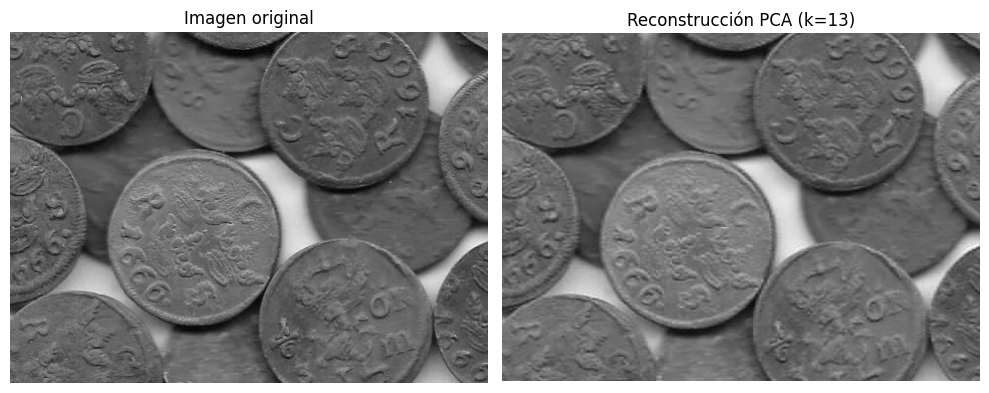

In [73]:
plt.figure(figsize=(10,5))

# Imagen original
plt.subplot(1,2,1)
plt.imshow(imagen_gris, cmap="gray")
plt.title("Imagen original")
plt.axis("off")

# Imagen reconstruida (comprimida)
plt.subplot(1,2,2)
plt.imshow(img_hat, cmap="gray")
plt.title(f"Reconstrucción PCA (k={k})")
plt.axis("off")

plt.tight_layout()
plt.show()

EJERCICIO 4 A)


In [74]:
def calcular_mse_vs_ahorro(ruta_img, bloque_size=8):
    """Calcula y grafica el MSE vs porcentaje de ahorro S."""
    # Convierto imagen a matriz en escala de grises
    img_gray = convertir_a_gris_float(ruta_img)
    # Obtengo dimensiones de la matriz
    alto, ancho = img_gray.shape
    X = imagen_a_bloques(img_gray, bloque_size, bloque_size)
    S_vals = [5*n for n in range(1, 20)]
    MSE_vals = []
    # Calculo bordes multiplos de los bloques
    alto_corte = alto - (alto % bloque_size)
    ancho_corte = ancho - (ancho % bloque_size)
    # Recorto imagen a tamano util para trabajar
    orig = img_gray[:alto_corte, :ancho_corte]

    for S in S_vals:
        # Utilizo max para no generar error en el ahorro del 100%
        k = max(1, int(np.ceil((1 - S/100) * bloque_size**2)))
        Y, media, componentes, _, _ = pca_transformar(X, k)
        X_reconstruido = Y @ componentes + media
        img_reconstruida = bloques_a_imagen(X_reconstruido, alto, ancho, bloque_size, bloque_size)
        rec = img_reconstruida[:alto_corte, :ancho_corte].astype(float)
        mse_val = np.mean((orig.astype(float) - rec)**2) // 255.0
        MSE_vals.append(mse_val)
        
    plt.figure(figsize=(8,5))
    plt.plot(S_vals, MSE_vals, "o-", label="MSE")
    plt.title("MSE vs porcentaje de ahorro")
    plt.xlabel("Ahorro S (%)")
    plt.ylabel("MSE")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

calcular_mse_vs_ahorro("./img_04.jpg")

FileNotFoundError: ./img_04.jpg

EJERCICIO 4B)

In [75]:
def mostrar_reconstrucciones(ruta_img, bloque_size=8, S_vals=[75,80,85,90,95]):
    """Grafica la imagen original y reconstrucciones para distintos S."""
    img_gray = convertir_a_gris_float(ruta_img)
    alto, ancho = img_gray.shape
    X = imagen_a_bloques(img_gray, bloque_size, bloque_size)
    alto_corte = alto - (alto % bloque_size)
    ancho_corte = ancho - (ancho % bloque_size)
    orig = img_gray[:alto_corte, :ancho_corte]
    recons = {}

    for S in S_vals:
        k = max(1, int(np.ceil((1 - S/100) * bloque_size**2)))
        Y, media, componentes, _, _ = pca_transformar(X, k)
        X_hat = Y @ componentes + media
        img_hat = bloques_a_imagen(X_hat, alto, ancho, bloque_size, bloque_size)
        recons[S] = np.clip(img_hat[:alto_corte, :ancho_corte], 0, 255)

    plt.figure(figsize=(12, 8))
    plt.subplot(2, 3, 1)
    plt.imshow(orig, cmap="gray")
    plt.title("Original")
    plt.axis("off")
    
    for i, S in enumerate(S_vals, start=2):
        plt.subplot(2, 3, i)
        plt.imshow(recons[S], cmap="gray")
        plt.title(f"Ahorro S={S}%")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

mostrar_reconstrucciones("./img_04.jpg")

FileNotFoundError: ./img_04.jpg